# Attempting to Model Elevator Situation with SimPy
## The Problem
My apartment building has three elevators, but one is reserved for freight. So, it really has two elevators which are called with one button. 

One of the elevators broke down, so the building opened the freight elevator up to the residents. The freight elevator has its own button on each floor.

I noticed one day as I was descending that my elevator kept stopping and no one would get in. The people in my building had started pressing both buttons and then getting in the elevator that arrived first.

That got me thinking about math. Here are my research questions:
1. Are we all worse off if everyone does this behavior?
2. Is there a threshold for how many people have to do this to make it worse?
3. Can we solve this problem through simulation and probability (numerical and analytical)?

I don't know much about queuing theory or probability, so this is going to be challenging for me. I will start with the numerical approach

# Dependencies

In [35]:
import random
import numpy as np

## Simplifying Assumption
- Elevator going down picks up people that want to be picked up (regardless of when they push button)
- If someone gets on at a non lobby floor, they're going to the lobby
- Elevator only stops on the way down to pick up
- Elevator drops off on its way up and on the way down at the lobby.

In [36]:
a = [(1,2), (3,4), (5,6)]
list(map(list, zip(*a)))
a + a

[(1, 2), (3, 4), (5, 6), (1, 2), (3, 4), (5, 6)]

# Defining an Elevator Class
We're going to have multiple elevators, which all do the same thing. Good time to make a class.

In [149]:
class Elevator(object):
    def __init__(self, name, debug=False):
        self.name = name
        self.loc = 0 # current floor
        self.moving_up = True # default is true because elevator starts on ground
        self.to_pick_up = [] 
        self.to_drop_off = [] 
        self.customers = [] 
        self.stopped = 0 # works as a timer, if its zero, not stopped
        self.idle = True # Elevator isn't doing anything
        self.throughput = 0# number of customers served
        self.average_times = []
        self.debug = debug

    def __str__(self):
        ans = self.name + ': '
        if self.idle:
            ans += 'idle'
        elif self.stopped > 0:
            ans += 'stopped'
        elif self.should_stop():
            ans += 'stopping to pick up or drop off'
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            ans += 'switching to idle'
        else:
            ans += f'moving, moving_up: {self.moving_up}'
        return ans
    
    def move(self):
        if self.idle:
            if self.debug:
                print(f'{self.name} sitting idle')
            return
        elif self.stopped > 0:
            # if stopped, stay stopped
            self.stopped -= 1
            if self.debug:
                print(f'{self.name} sitting stopped with {self.stopped} seconds to go')

        elif self.should_stop():
            self.pick_up_and_drop_off()
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            if self.debug:
                print(f'{self.name} has no one to pick up or drop off, switching to idle')
            self.idle = True
        else:
            self.loc += 1 if self.moving_up else -1
            if self.loc > 23: # bounds checking
                self.loc = 23
                self.moving_up = False
            if self.loc < 0:
                self.loc = 0
                self.moving_up = True
                
            if self.debug:
                print(f'{self.name} moved to location {self.loc}')
                
    def should_stop(self):
        if self.moving_up: # stop to drop off people
            if len(self.to_drop_off) == 0: # elevator is empty, picking heads up
                for customer in self.to_pick_up:
                    if customer.curr == self.loc:
                        return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
        else:
            for customer in self.to_pick_up:
                if customer.curr == self.loc:
                    return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
                
    def new_customer(self, customer):
        self.to_pick_up.append(customer)
        self.idle = False
    
    def pick_up(self):
        for customer in self.to_pick_up:
            if customer.curr == self.loc:
                self.to_pick_up.remove(customer)
                if customer.on_elevator == None:
                    # customer isn't already on an elevator
                    if self.debug:
                        print(f'{self.name} picked up customer {customer} at floor {self.loc}')

                    self.to_drop_off.append(customer)
                    customer.on_elevator = self
                
    def drop_off(self):
        for customer in self.to_drop_off:
            if customer.dest == self.loc:
                if self.debug:
                    print(f'{self.name} dropped off customer {customer} at floor {self.loc}')
                self.to_drop_off.remove(customer)
                self.average_times.append(i-customer.start_time)
                self.throughput += 1

    def pick_up_and_drop_off(self):
        # dropping people off
        # which direction to proceed?
        if self.moving_up:
            # elevators only drops off on the way up, unless its the last stop
            self.drop_off()
            
            # keep moving up if:
            # people need to be dropped off above current location
            # possibly: elevator is empty and people need to be picked up above current location
            continue_moving_up = False
            for cust in self.to_drop_off:
                if cust.dest > self.loc:
                    continue_moving_up = True
                    break
                if self.debug:
                    print(f'{self.name} just stopped, moving up to get drop off another customer')
            self.moving_up = continue_moving_up            
        if not self.moving_up:
            # keep moving down, unless you're at the lobby 
            self.pick_up() 
            if self.loc == 0: # at lobby, drop people off
                self.drop_off()
            self.moving_up = True if self.loc == 0 else False
            if self.debug:
                if self.moving_up:
                    print(f'{self.name} just stopped, moving up from the lobby')
                else:
                    print(f'{self.name} just stopped, moving down to drop people off')

        self.stopped = 5 # need to stop to pick people up


# Define Customer Class
The customer class does not have much logic. The key is to randomly generate current floor and destination floor

In [150]:
class Customer(object):
    def __init__(self, start_time, cust_number):
        self.number = cust_number
        rand = np.random.random()
        randint = np.random.randint(3,23)
        # half the time, someone gets on at the lobby, other half someone gets on a random floor
        self.curr, self.dest = (0, np.random.randint(3,23)) if rand <= .5 else (np.random.randint(3,23), 0) 
        self.start_time = start_time
        self.on_elevator = None # which elevator customer entered
        
    def __str__(self):
        return f'customer number {self.number} called elevator from {self.curr} to go to {self.dest}'

# Define Parameters and Run Simulation

In [151]:
WAIT_TIME = 5
time_steps = 3600 # number of seconds in simulation (one hour)
n_floors = 23 
poisson_lambda = 20 #number of seconds that pass before someone demands an elevator
sec_p_floor = 1 # seconds per floor (without someone there)
sec_stop = 5 #time it takes to stop
arrivals = np.random.poisson(lam=poisson_lambda, size=1000).cumsum()
cust_number = 0 
debug = False
meta_debug = True

def plot_hotel():
    text_output = "\n\n"
    customers_waiting = list(set(e1.to_pick_up) | set(e2.to_pick_up))
    for i in range(n_floors, -1, -1):
        text_output += f'\nfloor {i}: '
        if e1.loc == i:
            text_output += str(e1) + ' '
        if e2.loc == i:
            text_output += str(e2) + ' '
        
        for c in customers_waiting:
            if c.curr == i:
                text_output += 'X'
        
    text_output += '\nElevator status:\n'
    text_output += e1.name + ': '
    text_output += ', '.join([str(cust.dest) for cust in e1.to_drop_off])
    text_output += '\n' + e2.name + ': '
    text_output += ', '.join([str(cust.dest) for cust in e2.to_drop_off])
    return text_output

e1 = Elevator('Service Elevator', debug=debug)
e2 = Elevator('Regular Elevator', debug=debug)

for i in range(time_steps):
    if debug:
        print(f'time step {i}')
    if meta_debug:
        print(f'time step {i}')
        print(plot_hotel())
    e1.move()
    e2.move()
    if i in arrivals:
        cust_number += 1
        temp = Customer(i, cust_number)
        if debug:
            print(f'customer wants to get picked up at {temp.curr} and dropped off at {temp.dest}')
        e1.new_customer(temp)
        e2.new_customer(temp)

time step 0



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: idle Regular Elevator: idle 
Elevator status:
Service Elevator: 
Regular Elevator: 
time step 1



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: idle Regular Elevator: idle 
Elevator status:
Service Elevator: 
Regular Elevator: 
time step 2



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
f

time step 1293



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: X
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: Regular Elevator: moving, moving_up: False 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: stopping to pick up or drop off X
Elevator status:
Service Elevator: 
Regular Elevator: 
time step 1294



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: X
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: Regular Elevator: moving, moving_up: False 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: stopped X
Elevator status:
Service Elevator: 18
Regular Elevator: 
time step 1295



floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: X
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: Regular Elevator:

time step 2908



floor 23: 
floor 22: X
floor 21: 
floor 20: X
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: Regular Elevator: moving, moving_up: False 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: Service Elevator: moving, moving_up: False 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: XX
Elevator status:
Service Elevator: 0
Regular Elevator: 
time step 2909



floor 23: 
floor 22: X
floor 21: 
floor 20: X
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: Regular Elevator: moving, moving_up: False 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: Service Elevator: moving, moving_up: False 
floor 3: 
floor 2: 
floor 1: 
floor 0: XX
Elevator status:
Service Elevator: 0
Regular Elevator: 
time step 2910



floor 23: 
floor 22: X
floor 21: 
floor 20: X
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
f

# Plotting

87
85


(array([77.,  4.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 12. ,  63.3, 114.6, 165.9, 217.2, 268.5, 319.8, 371.1, 422.4,
        473.7, 525. ]),
 <a list of 10 Patch objects>)

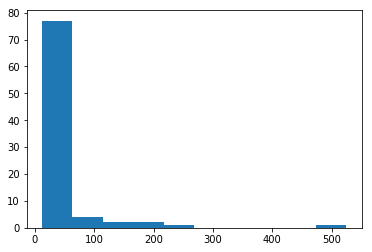

In [156]:
import matplotlib.pyplot as plt

print(e1.throughput)
print(e2.throughput)
plt.hist(e1.average_times)

In [153]:
#e2.to_pick_up
e1.to_pick_up